In [1]:
import glob
import os
import pandas as pd
import numpy as np
import time
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.layers import LSTM
from keras.models import Sequential
from keras.layers import Dense
import keras.backend as K
from keras.callbacks import EarlyStopping


print("...beginning loading data...")
curr_file_list = glob.glob(os.path.join('../GET_DATA/preprocessing/txt/ASW/', '*txt'))

DataList=[]
c=0
for filename in sorted(curr_file_list):
    with open(filename) as file:
        data = pd.read_csv(file, sep='\t', header=None, names=['dateGMT', 'timeGMT', 'unixTime', 'lat', 'lon'])
        data["timeGMT"] = data["timeGMT"].str.replace(pat=r'\|000|\|00', repl=r'', regex=True)
        data["timeGMT"] = data["timeGMT"].str.replace(pat=r':', repl=r'', regex=True)
        data["dateGMT"] = data["dateGMT"].str.replace(pat=r'|', repl='', regex=True)
        data["unixTime"] = data["unixTime"].str.replace(pat=r'\|000|\|00', repl=r'', regex=True)
#         data["dateTimeGMT"] = pd.to_datetime(data["dateGMT"]+data["timeGMT"], format='%Y%m%d%H%M%S')
        data.drop(['dateGMT', 'timeGMT','unixTime'], axis=1, inplace=True)
        DataList.append([c,data])
        c+=1

...beginning loading data...


In [2]:
def split(data):
    l=int(len(data)*0.6)
    
    train=data.loc[:l]
    test=data.loc[l:]
    
    return [train,test]

In [3]:
t=int(input('dataset: '))
if DataList[t][1].shape[0]<100:
    print('data is too small')
else:
    train_data,test_data=split(DataList[t][1])
    train_data,validation_data=split(train_data)

dataset: 9


In [4]:
print(len(train_data),len(validation_data),len(test_data))

51 34 56


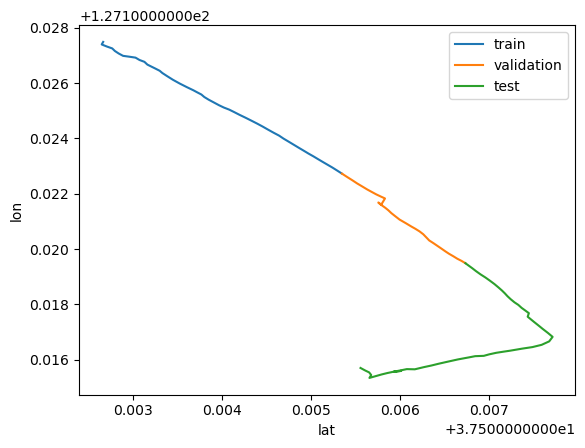

In [5]:
plt.plot(train_data['lat'],train_data['lon'])
plt.plot(validation_data['lat'],validation_data['lon'])
plt.plot(test_data['lat'],test_data['lon'])
plt.legend(['train', 'validation','test'])
plt.xlabel('lat')
plt.ylabel('lon')
plt.show()

In [6]:
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler()

train_sc = sc.fit_transform(train_data)
validation_sc=sc.fit_transform(validation_data)
test_sc = sc.transform(test_data)

In [7]:
train_sc_df = pd.DataFrame(train_sc, columns=['Scaled_lat','Scaled_lon'], index=train_data.index)
validation_sc_df = pd.DataFrame(validation_sc, columns=['Scaled_lat','Scaled_lon'], index=validation_data.index)
test_sc_df = pd.DataFrame(test_sc, columns=['Scaled_lat','Scaled_lon'], index=test_data.index)
train_sc_df.head()

,Scaled_lat,Scaled_lon
0,0.006173,1.000000
1,0.000000,0.980756
2,0.021605,0.965010
3,0.043827,0.950665
4,0.054938,0.931071


In [8]:
def avd(d):
    return np.mean(d)

from math import radians, cos, sin, asin, sqrt

def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance in kilometers between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles. Determines return value units.
    return c * r

In [9]:
def run(train,validation,w):
    train_sc_df=train
    validation_sc_df=validation
    w=w
    for s in range(1, w):
        train_sc_df['shift_{}_lat'.format(s)],train_sc_df['shift_{}_lon'.format(s)] = train_sc_df['Scaled_lat'].shift(s),train_sc_df['Scaled_lon'].shift(s)
        validation_sc_df['shift_{}_lat'.format(s)],validation_sc_df['shift_{}_lon'.format(s)] = validation_sc_df['Scaled_lat'].shift(s),validation_sc_df['Scaled_lon'].shift(s)

    k=w-1
    X_train = train_sc_df.dropna().drop(['shift_{}_lat'.format(k),'shift_{}_lon'.format(k)], axis=1)
    y_train = train_sc_df.dropna()[['shift_{}_lat'.format(k),'shift_{}_lon'.format(k)]]
    X_validation=validation_sc_df.dropna().drop(['shift_{}_lat'.format(k),'shift_{}_lon'.format(k)], axis=1)
    y_validation=validation_sc_df.dropna()[['shift_{}_lat'.format(k),'shift_{}_lon'.format(k)]]

   
    X_train=X_train.values
    y_train=y_train.values
    X_validation=X_validation.values
    y_validation=y_validation.values
   
    X_train_t = X_train.reshape(X_train.shape[0], k, 2)
    X_validation_t=X_validation.reshape(X_validation.shape[0],k,2)
    
    K.clear_session()
    model = Sequential() # Sequeatial Model
    model.add(LSTM(200, input_shape=(k, 2))) # (timestep, feature)
    model.add(Dense(100))
    model.add(Dense(2)) # output = 1
    model.compile(loss='mean_squared_error', optimizer='adam',metrics=['accuracy'])
    
    p=5 #int(input('patience : '))
    early_stop = EarlyStopping(monitor='loss',mode='auto',patience=p, verbose=1)

    result=model.fit(X_train_t, y_train, epochs=100,
              batch_size=32, verbose=1, callbacks=[early_stop])
    
    y_pred = model.predict(X_validation_t)
    y_pred = sc.inverse_transform(y_pred)
    y_pred_df = pd.DataFrame(y_pred, columns=['prediction_lat','prediction_lon'])
    Y_validation=sc.inverse_transform(y_validation)
    
    df_cities = pd.DataFrame({'위도':Y_validation[:,0], '경도':Y_validation[:,1]},index=[i for i in range(len(Y_validation))])
    d=[]
    for i in range(len(df_cities)):
         d.append(haversine(df_cities.iloc[i][0],df_cities.iloc[i][1],y_pred[i][0],y_pred[i][1]))
            
    return avd(d)

In [10]:
result=[]
for i in range(5,15):
    result.append(run(train_sc_df,validation_sc_df,i))



Epoch 1/100
2/2 [==============================] - 27s 8ms/step - loss: 0.3669 - accuracy: 0.4512
Epoch 2/100
2/2 [==============================] - 0s 8ms/step - loss: 0.2096 - accuracy: 0.9366
Epoch 3/100
2/2 [==============================] - 0s 6ms/step - loss: 0.1017 - accuracy: 0.9470
Epoch 4/100
2/2 [==============================] - 0s 5ms/step - loss: 0.0346 - accuracy: 0.9366
Epoch 5/100
2/2 [==============================] - 0s 7ms/step - loss: 0.0199 - accuracy: 0.9328
Epoch 6/100
2/2 [==============================] - 0s 5ms/step - loss: 0.0318 - accuracy: 0.9366
Epoch 7/100
2/2 [==============================] - 0s 5ms/step - loss: 0.0271 - accuracy: 0.9754
Epoch 8/100
2/2 [==============================] - 0s 5ms/step - loss: 0.0125 - accuracy: 1.0000
Epoch 9/100
2/2 [==============================] - 0s 6ms/step - loss: 0.0051 - accuracy: 0.9754
Epoch 10/100
2/2 [==============================] - 0s 4ms/step - loss: 0.0065 - accuracy: 0.9754
Epoch 11/100
2/2 [==========

In [11]:
index=result.index(min(result))
model_num=index+5
print(result[index])
print(model_num)

0.010038026435549354
6


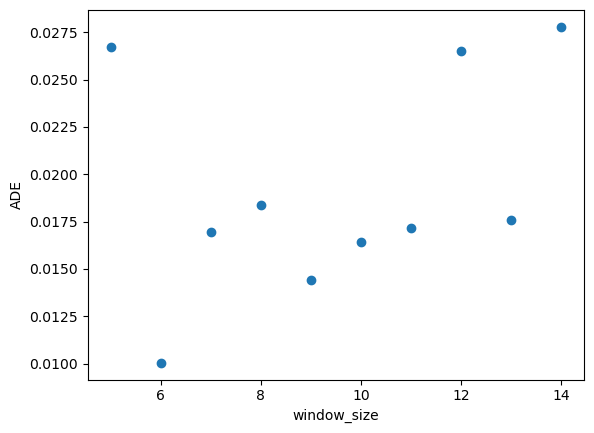

In [12]:
plt.scatter(range(5,15),result)
plt.xlabel('window_size')
plt.ylabel('ADE')
plt.show()